In [1]:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# pip install transformers diffusers accelerate matplotlib

In [1]:
# huggingface
from huggingface_hub import HfApi
from transformers import pipeline
from huggingface_hub import hf_hub_download
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler, DDPMScheduler

# torch
import torch
import torchvision.transforms as t

# misc
import numpy as np
from PIL import Image
from tqdm.auto import trange
from matplotlib import pyplot as plt

# text gen imports
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

/home/mykola/projects/diffusion/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
text_to_im_model_id = "stabilityai/stable-diffusion-2" #@param ["stabilityai/stable-diffusion-2-base", "stabilityai/stable-diffusion-2"]

scheduler = EulerDiscreteScheduler.from_pretrained(text_to_im_model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(text_to_im_model_id, scheduler=scheduler, revision="fp16", torch_dtype=torch.float16)
pipe = pipe.to('cuda' if torch.cuda.is_available() else 'cpu')

if text_to_im_model_id=="stability/stable-diffusion-2":
    pipe.enable_attention_slicing()

In [3]:
text_to_im_model_id = "stabilityai/stable-diffusion-2" #@param ["stabilityai/stable-diffusion-2-base", "stabilityai/stable-diffusion-2"]

scheduler = EulerDiscreteScheduler.from_pretrained(text_to_im_model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(text_to_im_model_id, scheduler=scheduler, revision="fp16", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

if text_to_im_model_id=="stability/stable-diffusion-2":
    pipe.enable_attention_slicing()

api = HfApi()

def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
        loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")
        
        # separate token and the embeds
        trained_token = list(loaded_learned_embeds.keys())[0]
        embeds = loaded_learned_embeds[trained_token]

        # cast to dtype of text_encoder
        dtype = text_encoder.get_input_embeddings().weight.dtype
        embeds.to(dtype)

        # add the token in tokenizer
        token = token if token is not None else trained_token
        num_added_tokens = tokenizer.add_tokens(token)
        i = 1

        # resize the token embeddings
        text_encoder.resize_token_embeddings(len(tokenizer))
        
        # get the id for the token and assign the embeds
        token_id = tokenizer.convert_tokens_to_ids(token)
        text_encoder.get_input_embeddings().weight.data[token_id] = embeds
        return token

textual_inversion_ids = ["minimaxir/wrong_embedding_sd_2_0"] #@param

models = []
for model in textual_inversion_ids:
    model_content = {}
    model_content["id"] = model
    embeds = (model, "learned_embeds.bin")
    embeds_file = hf_hub_download(embeds[0], embeds[1])
    
    token_identifier = (model, "token_identifier.txt")
    tokens_file = hf_hub_download(token_identifier[0], token_identifier[1])

    token_name = open(tokens_file, "r").read()
    print("adding", token_name)

    learned_token = load_learned_embed_in_clip(embeds_file, pipe.text_encoder, pipe.tokenizer, token_name)
    model_content["token"] = learned_token
    models.append(model_content)

prompt_tuner = "crumb/bloom-560m-RLHF-SD2-prompter-aesthetic" #@param ["crumb/bloom-560m-RLHF-SD2-prompter-aesthetic", "crumb/bloom-560m-RLHF-SD2-prompter"]
prompt_pipe = pipeline("text-generation", model=prompt_tuner)

# image gen params
temperature = 0.1 
max_length = 42 
guidance_scale = 7.5 
height = 760
width = 760
steps = 60
num_loops = 1 

def makeimage(prompt):
    prompt = "<s>Prompt: " + prompt + ","
    for _ in trange(num_loops):
        image = pipe(prompt, 
                    num_inference_steps=steps, 
                    height=height, width=width,
                    guidance_scale=guidance_scale).images[0]  
        image.save("output.png")

adding <wrong>


100%|██████████| 1/1 [00:16<00:00, 16.00s/it]


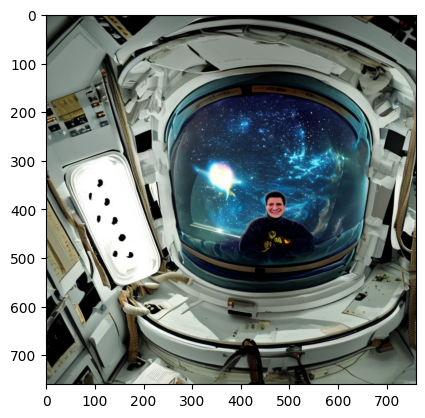

In [15]:
prompt = 'Ryan in space'
makeimage(prompt)
image = Image.open('output.png')
plt.imshow(image)
plt.show()

In [8]:
torch.cuda.empty_cache()

In [ ]:
# useful commands

# install missing libraries
# sudo apt install nvidia-cudnn

# check GPU usage
# nvidia-smi

# python3 -m venv venv
# . venv/bin/activate